# Exercise 5. Classification, shallow learning

The aim of this exercise is to train 4 different shallow learning models to predict different land-use classes from satellite data. It also assesses the model accuracy with a test dataset.

## Input data

2 raster files with:

* Coordinate system: Finnish ETRS-TM35FIN, EPSG:3067
* Resolution: 20m
* BBOX: 200000, 6700000, 300000, 6800000

#### Labels

* Multiclass classification raster: 1 - forest, 2 - fields, 3 - water, 4 - urban, 0 - everything else.

#### Data image

* Sentinel2 mosaic, with data from 2 different dates (May and July), to have more data values. Dataset has 8 bands based on bands: 2, 3, 4 and 8 on dates: 2021-05-11 and 2021-07-21, reflection values scaled to [0 ... 1]. The bands source data is: 
     *  'b02' / '2021-05-11'
     *  'b02' / '2021-07-21'
     *  'b03' / '2021-05-11'
     *  'b03' / '2021-07-21'
     *  'b04' / '2021-05-11'
     *  'b04' / '2021-07-21'
     *  'b08' / '2021-05-11'
     *  'b08' / '2021-07-21'

## Results

The trained models: 
* Random forest
* Stochastic Gradient Decent
* Gradient Boost
* SVM Suppot Vector Classifier

For each model:
* Trained model
* Model accuracy estimation
* Class confusion matrix
* Predicted image

## Main steps

1) Read data and shape it to suitable form for scikit-learn.
2) Resample to balance the dataset.
3) Divide the data to test and training datasets.
4) For each model:
   * Train the model.
   * Estimate the model on test data, inc class confusion matrix classification report creation.
   * Predict classification based on the data image and save it.
5) For SVM use grid search to find optimal settings.
6) Plot the results

## Imports and paths

In [2]:
import os, time
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import from_bounds
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
%matplotlib inline

In [3]:
### File paths.
### Change the base_folder if needed
user = os.environ.get('USER')

base_folder = os.path.join('/scratch/project_2002044/students', user, 'training023/GeoML/02_shallows')

image_url = 'https://a3s.fi/gis-courses/gis_ml/image.tif'
multiclass_classification_url = 'https://a3s.fi/gis-courses/gis_ml/labels_multiclass.tif'

outputBaseFolder= os.path.join(base_folder,'02_shallows')

# Input
image_file = os.path.join(base_folder, 'image.tif')
multiclass_classification_file = os.path.join(base_folder, 'labels_multiclass.tif')

no_bands_in_image = 8

# BBOX for exercise data, we use less than full image for shallow learning training, because of speed and to better see the results when plotting.
minx = 240500
miny = 6775500
maxx = 253500
maxy = 6788500 

# Available cores. During the course only 1 core is available, otherwise more cores could be available, so increase this then.
n_jobs = 1

(Download input data if needed.)

In [4]:
if not os.path.exists(image_file):
    urllib.request.urlretrieve(image_url, image_file)
    
if not os.path.exists(multiclass_classification_file):
    urllib.request.urlretrieve(multiclass_classification_url, multiclass_classification_file) 

## Read data and shape it to suitable form for scikit-learn

Read the input datasets with Rasterio and shape it to suitable form for scikit-learn.

Exactly the same as for K-means for image data, the similar processing only added for the labels image.

### Satellite image

The satellite image has 8 channels, so rasterio reads it in as 3D data cube.

For scikit-learn we reshape the data to 2D, having in dataframe one row for each pixel. Each pixel has eight values, one for each band/date.

In [5]:
# Read the pixel values from .tif file as dataframe
with rasterio.open(image_file) as image_dataset:
    image_data = image_dataset.read(window=from_bounds(minx, miny, maxx, maxy, image_dataset.transform))

# Check shape of input data
print ('Dataframe original shape, 3D: ', image_data.shape)    

Dataframe original shape, 3D:  (8, 650, 650)


As a mid-step transponse the axis order, so that the bands are the last. Notice how the dataframe size changes.

In [6]:
image_data2 = np.transpose(image_data, (1, 2, 0))
# Check again the data shape, now the bands should be last.
print ('Dataframe shape after transpose, 3D: ', image_data2.shape) 

Dataframe shape after transpose, 3D:  (650, 650, 8)


In [7]:
# Then reshape to 2D.
pixels = image_data2.reshape(-1, no_bands_in_image)
print ('Dataframe shape after transpose and reshape, 2D: ', pixels.shape) 

Dataframe shape after transpose and reshape, 2D:  (422500, 8)


### Labels

Do the same for labels.

In [8]:
# For labels only reshape to 1D is enough.
with rasterio.open(multiclass_classification_file) as labels_src:
    labels_data = labels_src.read(window=from_bounds(minx, miny, maxx, maxy, labels_src.transform))
    input_labels = labels_data.reshape(-1)
    print ('Labels shape after reshape, 1D: ', input_labels.shape)

Labels shape after reshape, 1D:  (422500,)


Notice that labels data has only one band.

In [9]:
labels_data.shape

(1, 650, 650)

### Divide the data to training, validation and test datasets

Set training, validation and test data ratios, how big part of the pixels is assigned to different sets.

In [10]:
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

First separate test set.

In [11]:
x_rest, x_test, y_rest, y_test = train_test_split(pixels, input_labels, test_size=test_ratio, random_state=63, stratify=input_labels)

... and then training and validation set, using the ratios set above and keeping class representation the same in all sets.

In [12]:
x_train1, x_validation, y_train1, y_validation= train_test_split(x_rest, y_rest, test_size=validation_ratio/(train_ratio + validation_ratio), random_state=63, stratify=y_rest)

### Resample to balance the dataset

The classes are very imbalanced in the dataset, so undersample the majority classes in the training set, so that all classes are represented about similar number of pixels. 
Notice that validation and test set keep the original class-distribution.

In [13]:
show_hist(labels_data)

In [14]:
rus = RandomUnderSampler(random_state=63)
x_train, y_train = rus.fit_resample(x_train1, y_train1)   
print ('Dataframe shape after undersampling of majority classes, 2D: ', x_train.shape)

Dataframe shape after undersampling of majority classes, 2D:  (17285, 8)


*How many pixels of different classes are included in training dataset?*

Notice that we lost a lot of pixel at this point, in real cases that may be undesired. See [inbalanced-learn User guide](https://imbalanced-learn.org/stable/user_guide.html#user-guide) for other options.

In [15]:
print('Labels before splitting:           ', np.unique(input_labels, return_counts=True)[1])
print('Training data before undersampling:', np.unique(y_train1, return_counts=True)[1])
print('Training data after undersampling: ', np.unique(y_train, return_counts=True)[1])
print('Validation data:                   ', np.unique(y_validation, return_counts=True)[1])
print('Test data:                         ', np.unique(y_test, return_counts=True)[1])

Labels before splitting:            [  4939 152652 105739 122273  36897]
Training data before undersampling: [  3457 106856  74017  85591  25828]
Training data after undersampling:  [3457 3457 3457 3457 3457]
Validation data:                    [  988 30531 21148 24455  7379]
Test data:                          [  494 15265 10574 12227  3690]


## Funcitons for training and estimating the models and predicting based on the models

Similar functions will be used by different algorithms. Here the functions are only defined, they will be used later.

### Train the model

In [16]:
# Train the model and see how long it took.
def trainModel(x_train, y_train, clf, classifierName):
    start_time = time.time()    
    # training the model
    clf.fit(x_train, y_train)
    print('Model training took: ', round((time.time() - start_time), 2), ' seconds')
    
    # Save the model to a file
    modelFilePath = os.path.join(outputBaseFolder, ('model_' + classifierName + '.sav'))
    dump(clf, modelFilePath) 
    return clf

### Estimate the model on test data

In [17]:
# Predict on test data and see the model accuracy
def estimateModel(clf, x_test, y_test):
    test_predictions = clf.predict(x_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, test_predictions))
    print('Classification report: \n', classification_report(y_test, test_predictions))

### Predict classification based on the data image and save it

In [18]:
# Predict on whole image and save it as .tif file
def predictImage(modelName):
    start_time = time.time()    
    
    #Set file paths
    classifiedImageFile = os.path.join(outputBaseFolder, ('classification_' + modelName + '.tif'))
    modelFile = os.path.join(outputBaseFolder, ('model_' + modelName + '.sav'))    
         
    #Load the model from the saved file
    trained_model = load(modelFile)

    # predict the class for each pixel
    prediction = trained_model.predict(pixels)

    # Reshape back to 2D
    print('Prediction shape in 1D: ', prediction.shape)
    prediction2D = np.reshape(prediction, (image_data.shape[1], image_data.shape[2]))
    print('Prediction shape in 2D: ', prediction2D.shape)

    # Save the results as .tif file.
    # Copy metadata from the labels image 
    outputMeta = labels_src.meta
    # Writing the image on the disk
    with rasterio.open(classifiedImageFile, 'w', **outputMeta) as dst:
        dst.write(prediction2D, 1)
    print('Predicting took: ', round((time.time() - start_time), 1), ' seconds')

## 5.3 Random forest     

In [19]:
classifierName = 'random_forest'
# Initialize the random forest classifier and give the hyperparameters.
clf_random_forest = RandomForestClassifier(n_estimators=200, max_depth=75, random_state=0, n_jobs=n_jobs)
clf_random_forest = trainModel(x_train, y_train, clf_random_forest, classifierName)
estimateModel(clf_random_forest, x_validation, y_validation)

Model training took:  4.31  seconds
Confusion matrix: 
 [[  636    88    59    18   187]
 [ 1292 25181  1012     2  3044]
 [ 1349   811 17035     4  1949]
 [  775    89    37 23375   179]
 [  593  1027   885    17  4857]]
Classification report: 
               precision    recall  f1-score   support

           0       0.14      0.64      0.23       988
           1       0.93      0.82      0.87     30531
           2       0.90      0.81      0.85     21148
           3       1.00      0.96      0.98     24455
           4       0.48      0.66      0.55      7379

    accuracy                           0.84     84501
   macro avg       0.69      0.78      0.69     84501
weighted avg       0.89      0.84      0.86     84501



*Feel free, to modify some some of the hyper-parameters above to get better results.*
And then see with test data, if the modifications help also for previously unseen data.

In [20]:
estimateModel(clf_random_forest, x_test, y_test)
predictImage(classifierName)
print('Feature importances: \n', clf_random_forest.feature_importances_)

Confusion matrix: 
 [[  327    48    22     6    91]
 [  679 12542   526     0  1518]
 [  610   387  8514     3  1060]
 [  375    45    17 11714    76]
 [  309   569   429     4  2379]]
Classification report: 
               precision    recall  f1-score   support

           0       0.14      0.66      0.23       494
           1       0.92      0.82      0.87     15265
           2       0.90      0.81      0.85     10574
           3       1.00      0.96      0.98     12227
           4       0.46      0.64      0.54      3690

    accuracy                           0.84     42250
   macro avg       0.68      0.78      0.69     42250
weighted avg       0.89      0.84      0.86     42250

Prediction shape in 1D:  (422500,)
Prediction shape in 2D:  (650, 650)
Predicting took:  9.0  seconds
Feature importances: 
 [0.10352619 0.08059291 0.1235314  0.08278717 0.14364013 0.10335479
 0.17572455 0.18684286]


## 5.4 Stochastic Gradient Decent

In [21]:
classifierName = 'SGD'    
clf_SGD = SGDClassifier(loss="log_loss", learning_rate='adaptive', eta0=.1, alpha=1e-5,  n_jobs=n_jobs, max_iter=2000, penalty='l1') #
clf_SGD = trainModel(x_train, y_train, clf_SGD, classifierName)
estimateModel(clf_SGD, x_validation, y_validation)

Model training took:  0.63  seconds
Confusion matrix: 
 [[  315   195   160   123   195]
 [  863 26290  1829    74  1475]
 [  920  1576 15855    67  2730]
 [  189   237   133 23820    76]
 [  414  1996  1308   525  3136]]
Classification report: 
               precision    recall  f1-score   support

           0       0.12      0.32      0.17       988
           1       0.87      0.86      0.86     30531
           2       0.82      0.75      0.78     21148
           3       0.97      0.97      0.97     24455
           4       0.41      0.42      0.42      7379

    accuracy                           0.82     84501
   macro avg       0.64      0.67      0.64     84501
weighted avg       0.84      0.82      0.83     84501



In [22]:
estimateModel(clf_SGD, x_test, y_test)
predictImage(classifierName)

Confusion matrix: 
 [[  161   106    88    65    74]
 [  441 13096   944    32   752]
 [  428   766  7894    32  1454]
 [  104   107    47 11935    34]
 [  211  1052   654   266  1507]]
Classification report: 
               precision    recall  f1-score   support

           0       0.12      0.33      0.18       494
           1       0.87      0.86      0.86     15265
           2       0.82      0.75      0.78     10574
           3       0.97      0.98      0.97     12227
           4       0.39      0.41      0.40      3690

    accuracy                           0.82     42250
   macro avg       0.63      0.66      0.64     42250
weighted avg       0.83      0.82      0.83     42250

Prediction shape in 1D:  (422500,)
Prediction shape in 2D:  (650, 650)
Predicting took:  0.2  seconds


# 5.5 Gradient Boost    

In [23]:
classifierName = 'gradient_boost'    
clf_gradient_boost = GradientBoostingClassifier(n_estimators=1000, learning_rate=.05)
clf_gradient_boost = trainModel(x_train, y_train, clf_gradient_boost, classifierName)
estimateModel(clf_gradient_boost, x_validation, y_validation)

Model training took:  130.08  seconds
Confusion matrix: 
 [[  608    90    60    17   213]
 [ 1323 25069   900    13  3226]
 [ 1473   790 16623    21  2241]
 [  711    78    36 23415   215]
 [  563   981   850    34  4951]]
Classification report: 
               precision    recall  f1-score   support

           0       0.13      0.62      0.21       988
           1       0.93      0.82      0.87     30531
           2       0.90      0.79      0.84     21148
           3       1.00      0.96      0.98     24455
           4       0.46      0.67      0.54      7379

    accuracy                           0.84     84501
   macro avg       0.68      0.77      0.69     84501
weighted avg       0.89      0.84      0.86     84501



In [24]:
estimateModel(clf_gradient_boost, x_test, y_test)
predictImage(classifierName)
print('Feature importances: \n', clf_gradient_boost.feature_importances_)    

Confusion matrix: 
 [[  304    57    23     7   103]
 [  694 12471   479     5  1616]
 [  709   422  8225     9  1209]
 [  376    32    18 11713    88]
 [  316   557   415    13  2389]]
Classification report: 
               precision    recall  f1-score   support

           0       0.13      0.62      0.21       494
           1       0.92      0.82      0.87     15265
           2       0.90      0.78      0.83     10574
           3       1.00      0.96      0.98     12227
           4       0.44      0.65      0.53      3690

    accuracy                           0.83     42250
   macro avg       0.68      0.76      0.68     42250
weighted avg       0.89      0.83      0.85     42250

Prediction shape in 1D:  (422500,)
Prediction shape in 2D:  (650, 650)
Predicting took:  13.4  seconds
Feature importances: 
 [0.03626299 0.06364205 0.10110151 0.02578718 0.16158957 0.08025872
 0.17327668 0.35808131]


## 5.6 SVM Support Vector Classifier

SVM is slower than others, wait a moment.

In [25]:
classifierName = 'SVM'        
clf_svc = SVC(kernel='rbf', gamma='auto',  decision_function_shape='ovr')
clf_svc = trainModel(x_train, y_train, clf_svc, classifierName)
estimateModel(clf_svc, x_validation, y_validation)

Model training took:  7.29  seconds
Confusion matrix: 
 [[  380   202   120   104   182]
 [  702 26731  1648    56  1394]
 [ 1062  1508 15267    54  3257]
 [  389   240    63 23721    42]
 [  481  2313  1146   464  2975]]
Classification report: 
               precision    recall  f1-score   support

           0       0.13      0.38      0.19       988
           1       0.86      0.88      0.87     30531
           2       0.84      0.72      0.78     21148
           3       0.97      0.97      0.97     24455
           4       0.38      0.40      0.39      7379

    accuracy                           0.82     84501
   macro avg       0.64      0.67      0.64     84501
weighted avg       0.84      0.82      0.83     84501



## 5.7 Grid Search for SVC

Different models have different settings (hyperparameters) that can be used for searching best model. Grid search is one option to automatically search for better option. For more options in hyperparameter search see [CSC machine learning guide](https://docs.csc.fi/support/tutorials/hyperparameter_search/)

Here we try different `C` and `gamma` values for the SVM model. Grid search automatically saves the best model.

*Notice, how the results are improved from the first SVM result above.*

In [26]:
classifierName = 'SVC_grid_search'        
# Find the optimal parameters for SVM
param_grid = {'C': [1000, 10000], 'gamma': [1, 10]}
# Initialize the grid search, cv is the number of iterations, kept at minimum here for faster results.
grid = GridSearchCV(SVC(), param_grid, verbose=1, n_jobs=n_jobs, cv=2)    
# Try different options
grid = trainModel(x_train, y_train, grid, classifierName)

# Plot the best option
print('Best selected parameters: ',format(grid.best_params_))
print('Best estimator: ',format(grid.best_estimator_))

# Test the classifier using test data
estimateModel(grid, x_test, y_test)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Model training took:  184.88  seconds
Best selected parameters:  {'C': 10000, 'gamma': 10}
Best estimator:  SVC(C=10000, gamma=10)
Confusion matrix: 
 [[  300    72    10     9   103]
 [  389 13142   375     0  1359]
 [  520   453  8504    13  1084]
 [  349    37    19 11728    94]
 [  200   663   384     7  2436]]
Classification report: 
               precision    recall  f1-score   support

           0       0.17      0.61      0.27       494
           1       0.91      0.86      0.89     15265
           2       0.92      0.80      0.86     10574
           3       1.00      0.96      0.98     12227
           4       0.48      0.66      0.56      3690

    accuracy                           0.85     42250
   macro avg       0.70      0.78      0.71     42250
weighted avg       0.89      0.85      0.87     42250



In [27]:
estimateModel(grid, x_validation, y_validation)

Confusion matrix: 
 [[  570   106    54    20   238]
 [  755 26391   723     7  2655]
 [ 1126   955 16996    23  2048]
 [  726    98    32 23383   216]
 [  351  1160   740    20  5108]]
Classification report: 
               precision    recall  f1-score   support

           0       0.16      0.58      0.25       988
           1       0.92      0.86      0.89     30531
           2       0.92      0.80      0.86     21148
           3       1.00      0.96      0.98     24455
           4       0.50      0.69      0.58      7379

    accuracy                           0.86     84501
   macro avg       0.70      0.78      0.71     84501
weighted avg       0.90      0.86      0.87     84501



In [28]:
predictImage(classifierName)  

Prediction shape in 1D:  (422500,)
Prediction shape in 2D:  (650, 650)
Predicting took:  125.4  seconds


## Plot the results

In [29]:
### Help function to normalize band values and enhance contrast. Just like what QGIS does automatically
def normalize(array):
    min_percent = 2   # Low percentile
    max_percent = 98  # High percentile
    lo, hi = np.percentile(array, (min_percent, max_percent))
    return (array - lo) / (hi - lo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot: title={'center': 'labels'}>

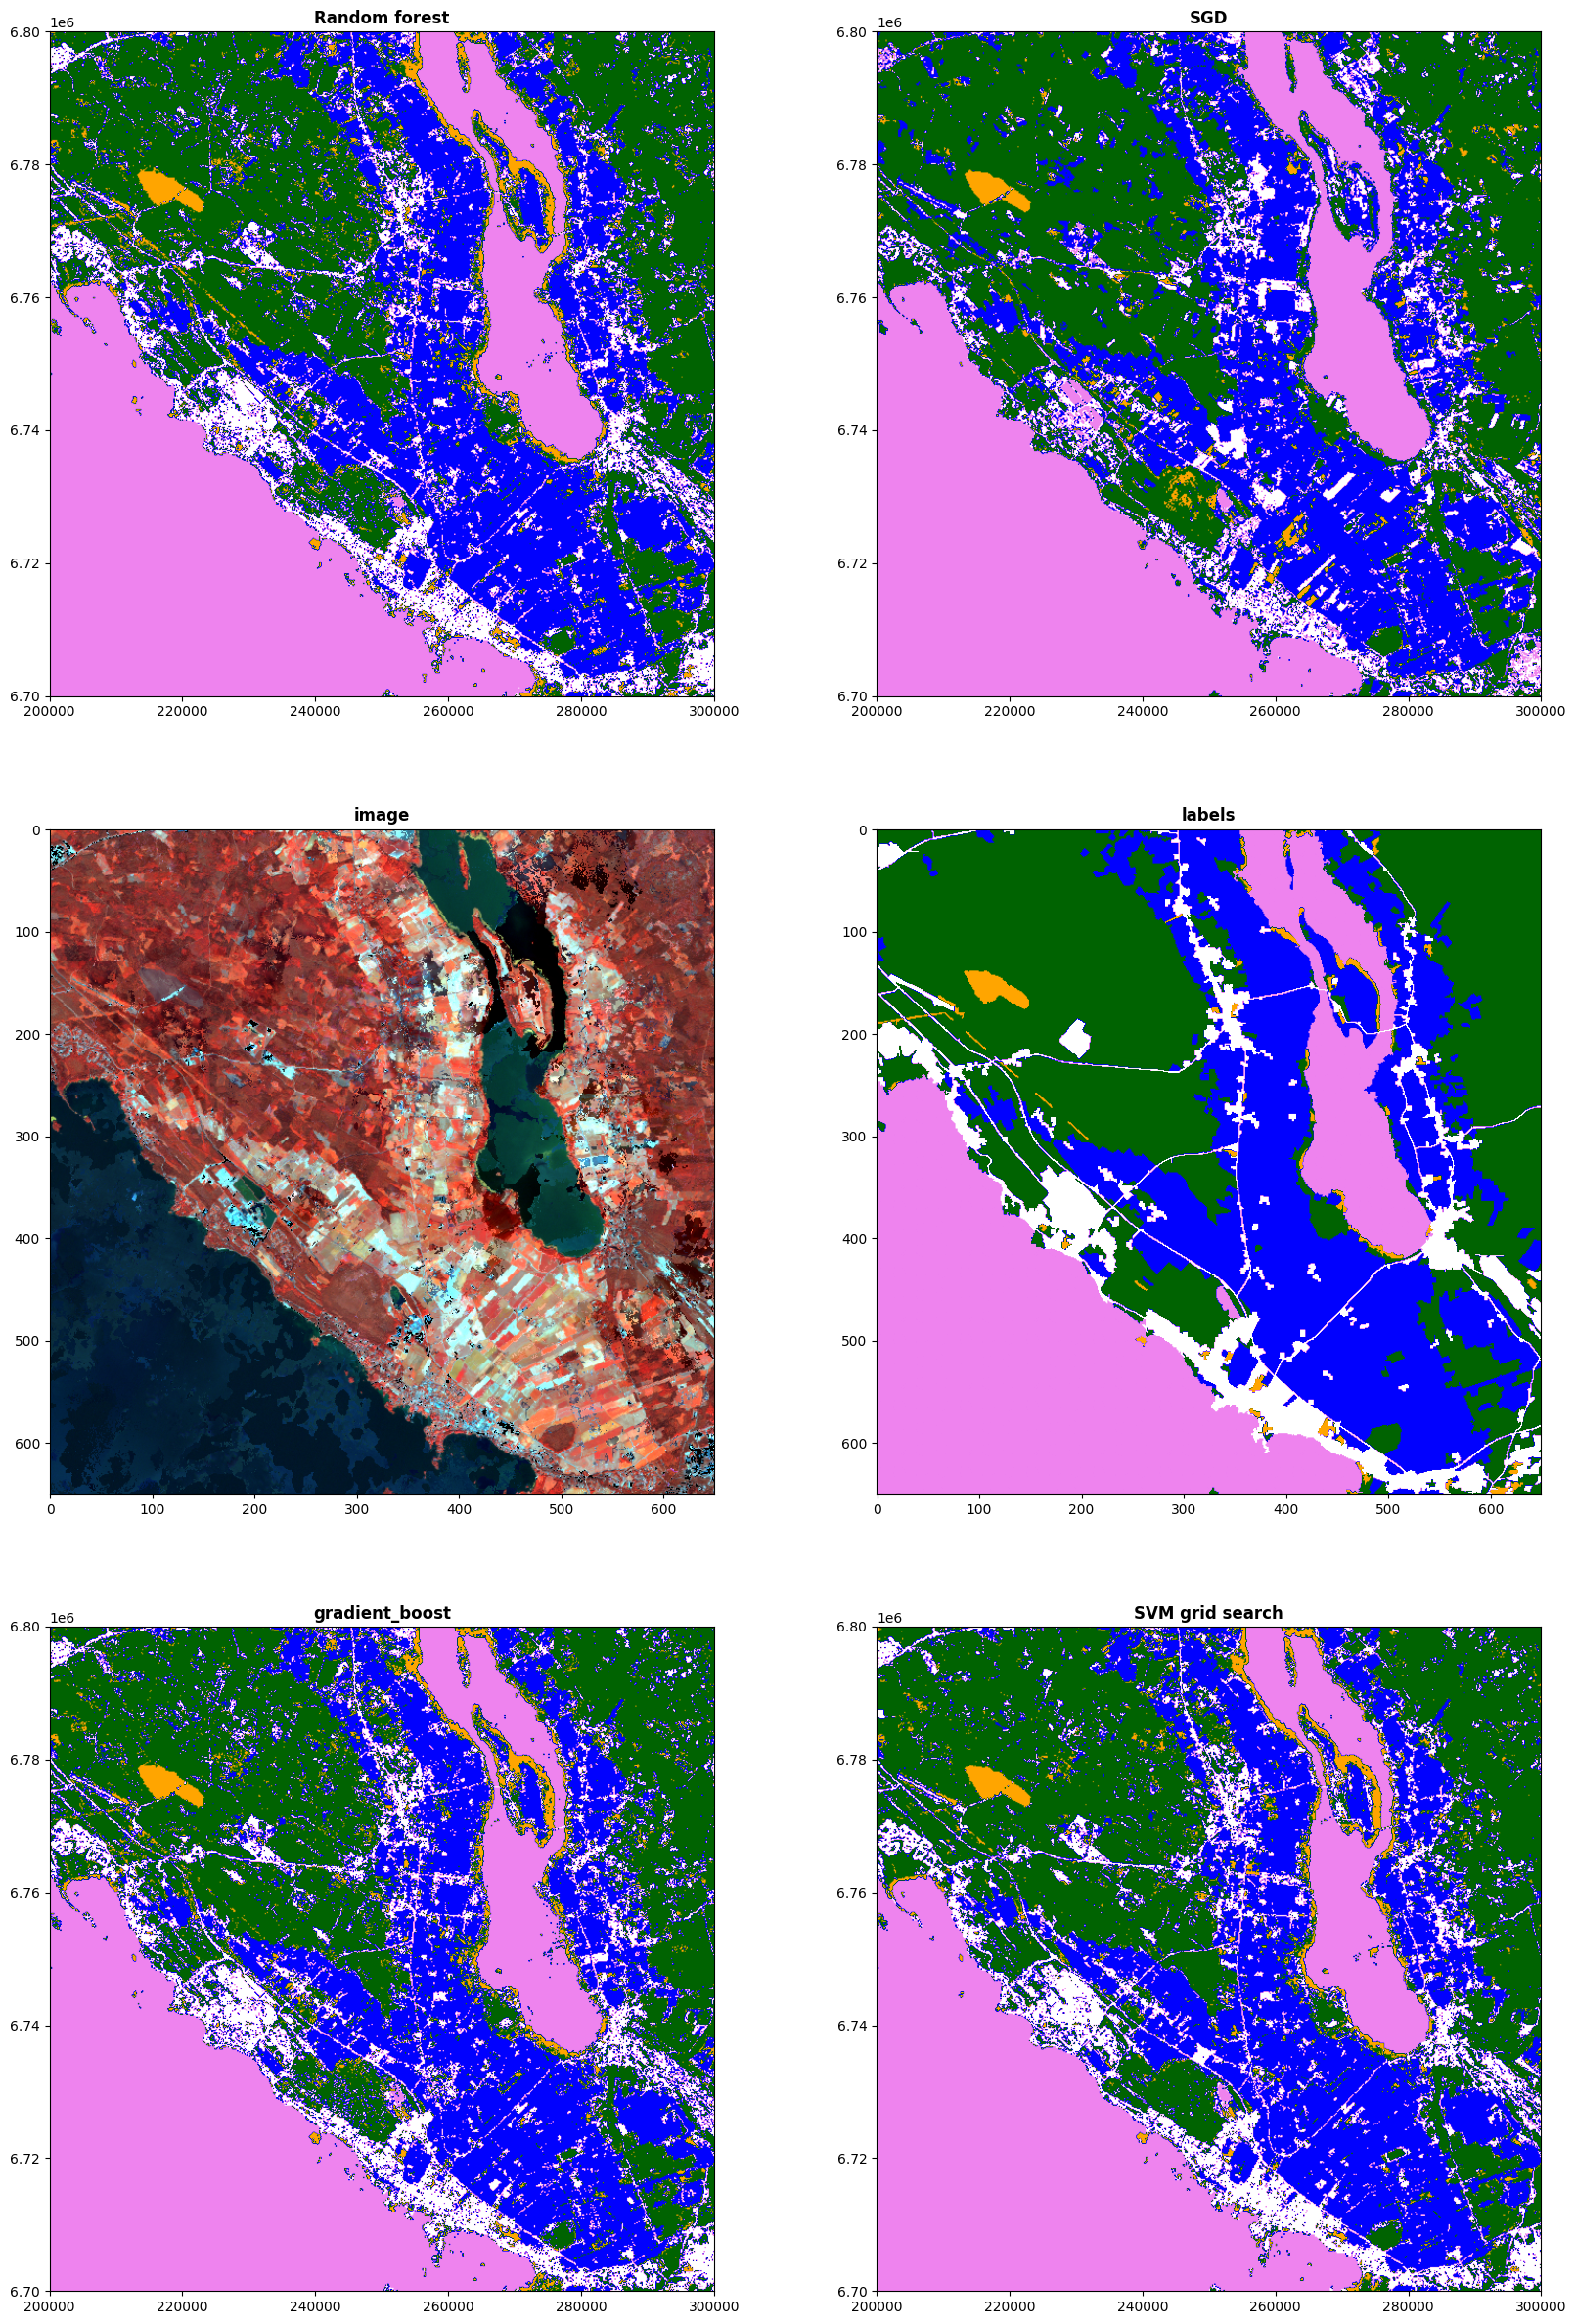

In [30]:
# Create a subplot for 6 images: 4 classification, 1 data image and 1 training labels. 
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 30))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","darkgreen","blue","violet","white"])

# The prediction results
rf_results = rasterio.open(os.path.join(outputBaseFolder,'classification_random_forest.tif'))
show(rf_results, ax=ax[0, 0], cmap=cmap, title='Random forest')

SGD_results = rasterio.open(os.path.join(outputBaseFolder,'classification_SGD.tif'))
show(SGD_results, ax=ax[0, 1], cmap=cmap, title='SGD')

gradient_boost_results = rasterio.open(os.path.join(outputBaseFolder,'classification_gradient_boost.tif'))
show(gradient_boost_results, ax=ax[2, 0], cmap=cmap, title='gradient_boost')

SVM_grid_search_results = rasterio.open(os.path.join(outputBaseFolder,'classification_SVC_grid_search.tif'))
show(SVM_grid_search_results, ax=ax[2, 1], cmap=cmap, title='SVM grid search')

# Plot the sentinel image 
nir, red, green = image_data[7,], image_data[3,], image_data[1,]
nirn, redn, greenn = normalize(nir), normalize(red), normalize(green)
stacked = np.stack((nirn, redn, greenn))
show(stacked, ax=ax[1,0], title='image') 

# Labels 
show(labels_data, ax=ax[1,1], cmap=cmap, title='labels')